# Image Processing CookBook
## Chapter 7
### Author - Sandipan Dey

### Human pose estimation using Deep Learning

In [1]:
%matplotlib inline
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

proto_file = "models/pose_deploy_linevec_faster_4_stages.prototxt"
weights_file = "models/pose_iter_160000.caffemodel"
n_points = 15
BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4, 
              "LShoulder": 5,  "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
             "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14, "Background": 15}

#POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
             ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
             ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
             ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]


image = cv2.imread("images/leander.jpg")
height, width = image.shape[:2]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)
blob = cv2.dnn.blobFromImage(image, 1.0 / 255, (368,368), (0, 0, 0), swapRB=False, crop=False)
net.setInput(blob)
output = net.forward()
h, w = output.shape[2:4]
print(output.shape)

(1, 44, 46, 46)


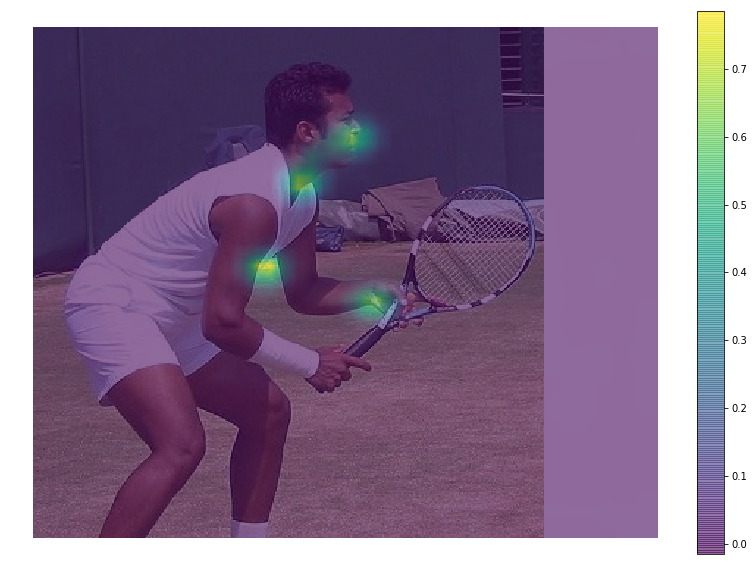

In [2]:
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
prob_map = np.zeros((width, height))
for i in range(1,5):
    pmap = output[0, i, :, :]
    prob_map += cv2.resize(pmap, (height, width))
plt.imshow(prob_map, alpha=0.6)
plt.colorbar()
plt.axis("off")
plt.show()

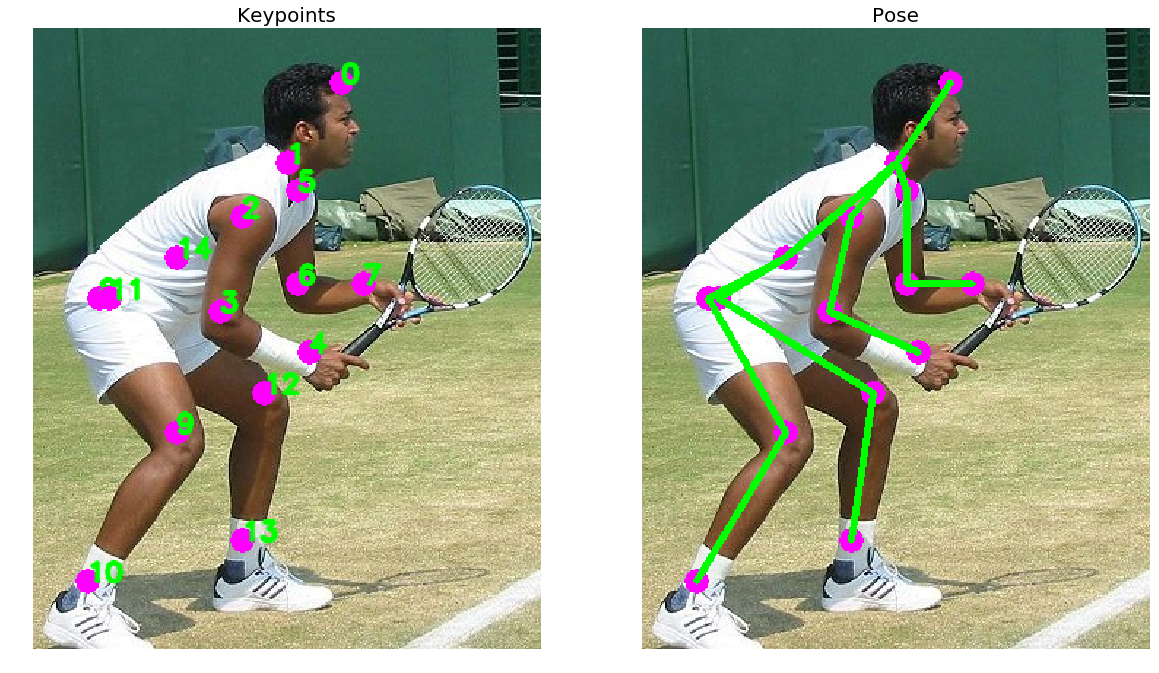

In [3]:
image1 = image.copy()

# Empty list to store the detected keypoints
points = []

for i in range(n_points):
    # confidence map of corresponding body's part.
    prob_map = output[0, i, :, :]

    # Find local maxima of the prob_map.
    min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)
    
    # Scale the point to fit on the original image
    x = (width * point[0]) / w
    y = (height * point[1]) / h

    if prob > threshold : 
        cv2.circle(image1, (int(x), int(y)), 8, (255, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(image1, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, lineType=cv2.LINE_AA)
        cv2.circle(image, (int(x), int(y)), 8, (255, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    part_from = BODY_PARTS[pair[0]]
    part_to = BODY_PARTS[pair[1]]

    if points[part_from] and points[part_to]:
        cv2.line(image, points[part_from], points[part_to], (0, 255, 0), 3)

plt.figure(figsize=[20,12])
plt.subplot(121), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Keypoints', size=20)
plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Pose', size=20)
plt.show()

### Image Classification with Fine Tuning

In [8]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
import matplotlib.pylab as plt
import numpy as np

train_dir = 'images/flower_photos/train'
validation_dir = 'images/flower_photos/valid'
image_size = 224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save('all_freezed.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<keras.engine.input_layer.InputLayer object at 0x7f10b1ca7b38> False
<keras.layers.convolutional.Conv2D object at 0x7f10acfe34a8> False
<keras.layers.convolutional.Conv2D object at 0x7f10b1ca7e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10ad034208> False
<keras.layers.convolutional.Conv2D object at 0x7f10ad034908> False
<keras.layers.convolutional.Conv2D object at 0x7f10acf391d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10acf54588> False
<keras.layers.convolutional.Conv2D object at 0x7f10acf54c88> False
<keras.layers.convolutional.Conv2D object at 0x7f10acf70978> False
<keras.layers.convolutional.Conv2D object at 0x7f10acf05828> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10acebb588> False
<keras.layers.convolutional.Conv2D object at 0x7f10acebbc88> False
<keras.layers.convolutional.Conv2D object at 0x7f10aced6978> False
<keras.layers.convolutional.Conv2D object at 0x7f10aceec828> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10acea1588>

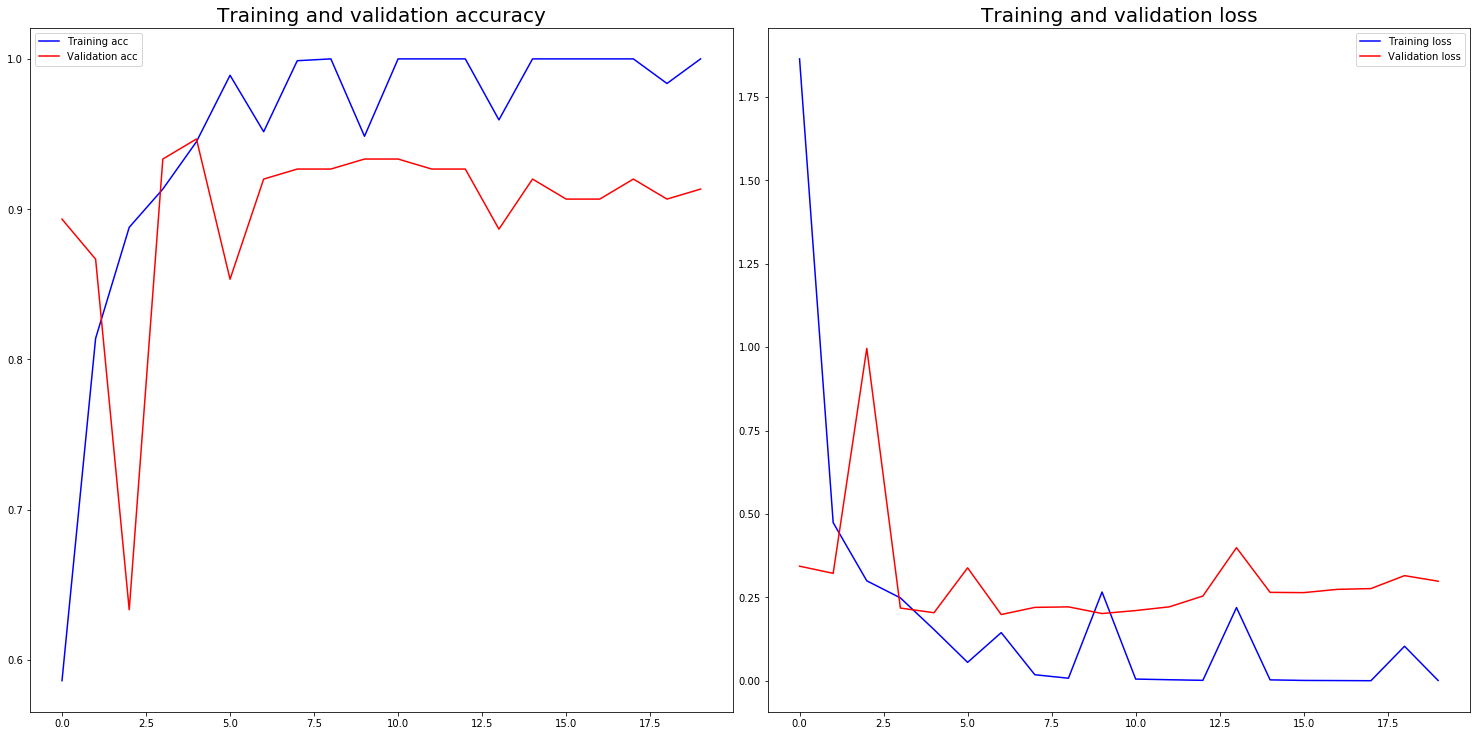

In [9]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0)
plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.legend(prop={'size': 10})
plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.legend(prop={'size': 10})

plt.show()

15/15 [==============================] - 2s 134ms/step
No of errors = 39/150


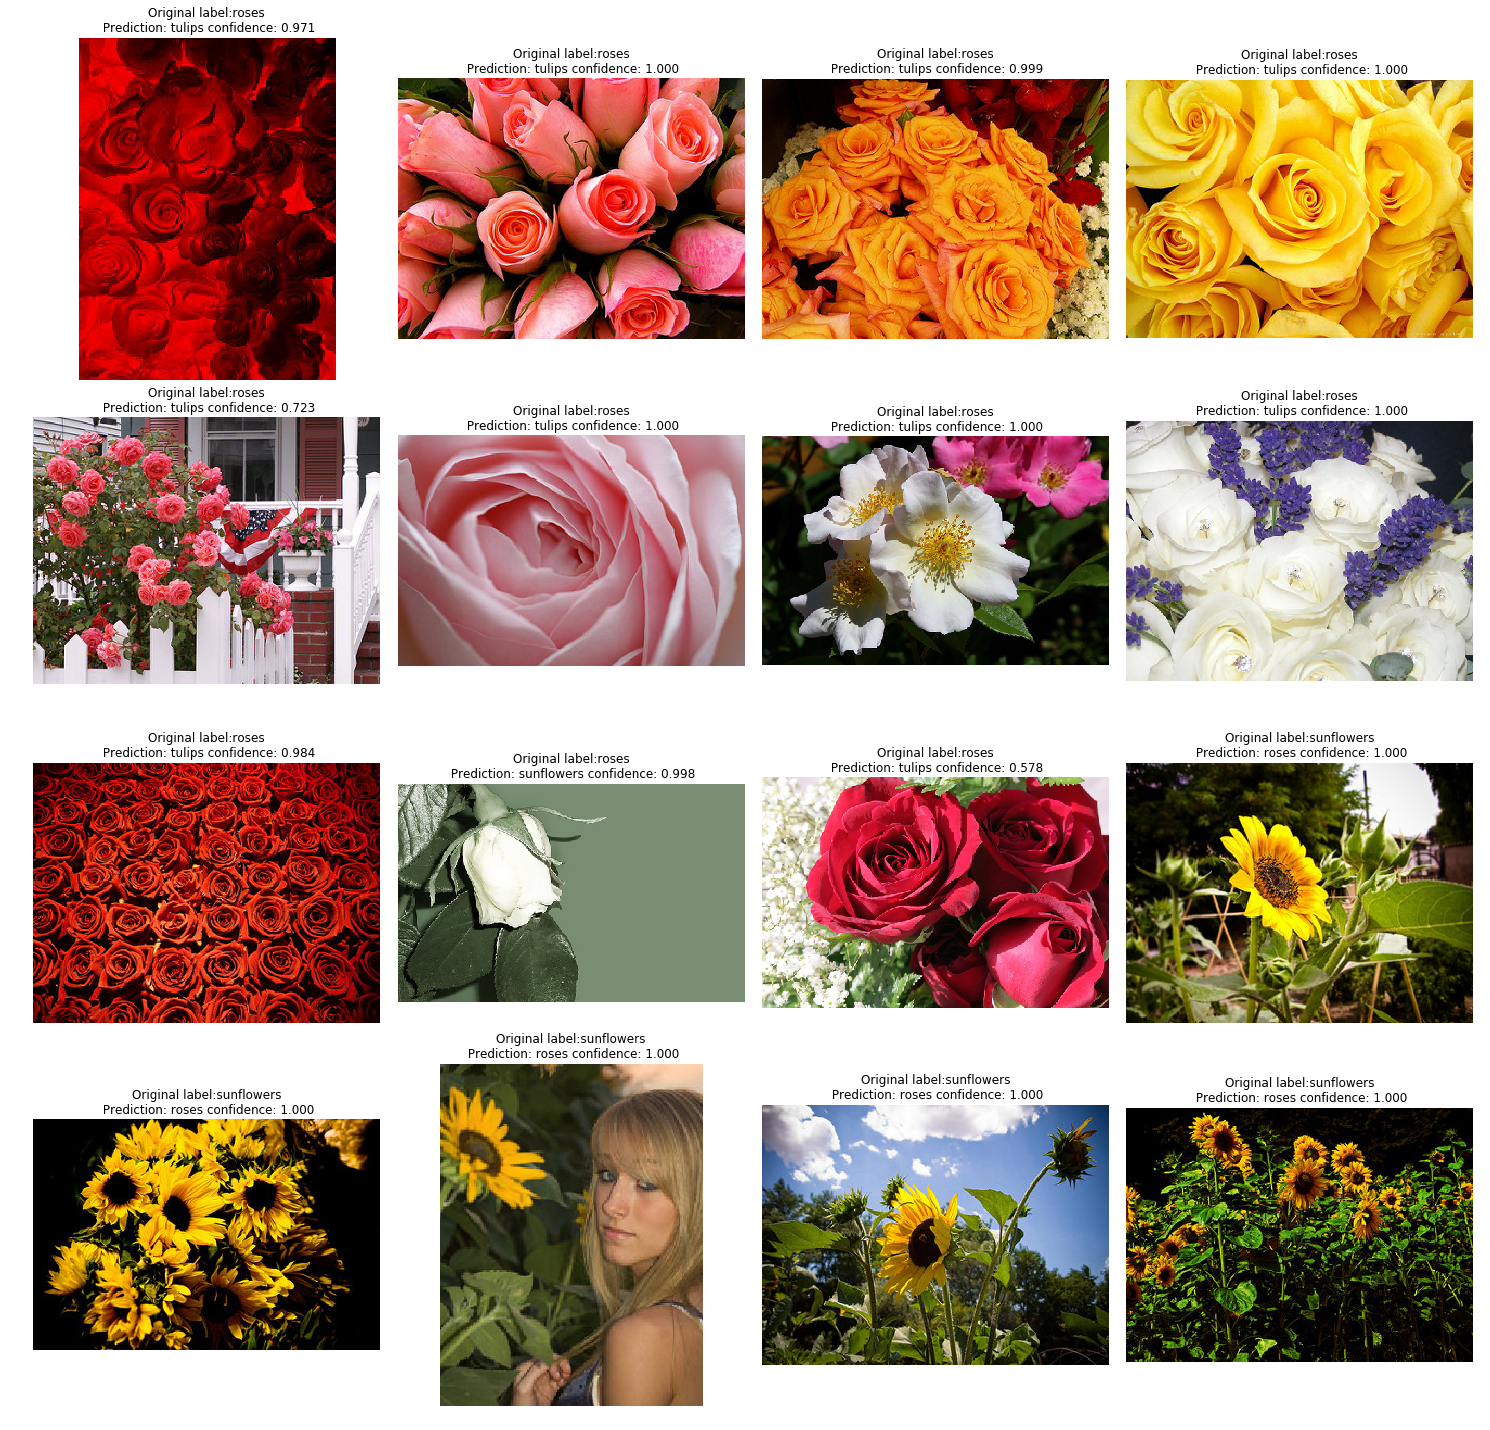

In [13]:
# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))


# Show the errors
plt.figure(figsize=[20,20])
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0)
for i in range(len(errors[:16])):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}\n Prediction: {} confidence: {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class], size=20)
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
plt.show()

In [46]:
#!pip3 install pydot-ng
#!apt-get  -y install graphviz 
import pydot_ng as pydot
from keras.utils import plot_model
plot_model(model, to_file='images/model.png')